# Image Generation using Variational AutoEncoders

The goal of Autoencoders was to generate latent vectors which are easily decodable back to the original image. But this can cause the latent space to become disjoint and non-continous.

Variational Autoencoders were introduced to remedy this. Variational Autoencoders are trained to learn the probability distribution that models the input data. In varional autoencoders, the inputs are mapped to a probability distribuion over latent vectors. Typically, this probability distribution is set to standard normal distribution. So, there are two targets in VAEs: one to minimize the reconstruction loss and two to minimize the KL divergence between the Probilitistic encoder and standard normal distribution.


!["Variational Autoencoder Architecture"](https://blog.bayeslabs.co/assets/img/vae-gaussian.png)

<p align = "center">
Fig.1 - Variational Autoencoder Architecture
(<a href=https://blog.bayeslabs.co/2019/06/04/All-you-need-to-know-about-Vae">
source
</a>)
</p>

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from tqdm import tqdm
import numpy as np

In [2]:
EPOCHS = 20
LEARNING_RATE = 1e-4
BATCH_SIZE = 64
Z = 32
KLD_WEIGHT = 0.0012

In [3]:
# We will be using the mnist digit data.
mnist_dataset = datasets.MNIST(root="minist_data/", download=True, transform=ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 177911955.93it/s]


Extracting minist_data/MNIST/raw/train-images-idx3-ubyte.gz to minist_data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 69458540.04it/s]


Extracting minist_data/MNIST/raw/train-labels-idx1-ubyte.gz to minist_data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 62938683.84it/s]

Extracting minist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to minist_data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 17820887.53it/s]


Extracting minist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to minist_data/MNIST/raw



In [4]:
# Initializing pytorch dataloader
train_dataloader = DataLoader(mnist_dataset, batch_size=BATCH_SIZE, shuffle=True)

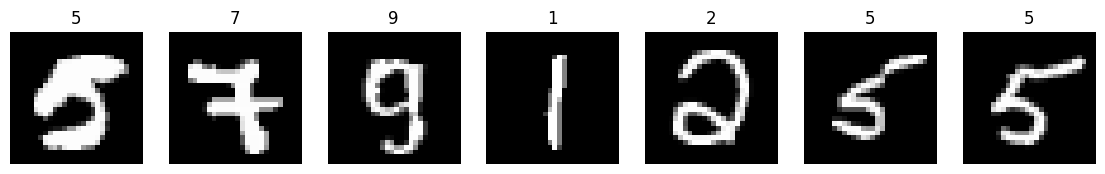

In [5]:
# Visualizing some sample images
figure = plt.figure(figsize=(14, 14))
cols, rows = 7, 1
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(mnist_dataset), size=(1,)).item()
    img, label = mnist_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

Here, we will define a model for a Variational Autoencoder. It is mostly similar to Autoencoders with a few differences. Instead of the encoder outputing a deterministic latent space representation like in autoencoders, the encoder will now output a mean and log variance vector. The latent space representation will then be sampled using them. We output log variance instead of just variance because the varaince always has to be postive.

The docoder is same as in autoencoders.

For sampling the latent space representation, we use a reparameterization trick so that it is possible to backpropagate. The basic idea is given below in the Fig 2.

!["Reparameteriztion Trick"](https://blog.bayeslabs.co/assets/img/vae_part_1_1.png)

<p align = "center">
Fig.2 - Reparameteriztion Trick
(<a href=https://blog.bayeslabs.co/2019/06/04/All-you-need-to-know-about-Vae">
source
</a>)
</p>



In [7]:
class Reshape(nn.Module):
  """A custom reshape layer."""
  def __init__(self, shape):
    super(Reshape, self).__init__()
    self.shape = shape

  def forward(self, x):
    return x.view(*self.shape)


class VariationalAutoEncoder(nn.Module):
  """Variational Autoencoder model"""
  def __init__(self, z):
    super(VariationalAutoEncoder, self).__init__()
    self.z = z
    self.encoder_top = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(16),
        nn.LeakyReLU(),

        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(),

        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(64),
        nn.LeakyReLU(),

        nn.Flatten(1,-1),
        nn.Linear(64 * 4 * 4, 128),
        nn.BatchNorm1d(128),
        nn.LeakyReLU(),
    )

    self.mu_layer =  nn.Linear(128, z)
    self.logvar_layer =  nn.Linear(128, z)

    self.decoder = nn.Sequential(
        nn.Linear(z, 128),
        nn.BatchNorm1d(128),
        nn.LeakyReLU(),

        nn.Linear(128, 64 * 4 * 4),
        nn.BatchNorm1d(64 * 4 * 4),
        nn.LeakyReLU(),

        Reshape((-1,64,4,4)),

        nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2, padding=1),
        nn.BatchNorm2d(32),
        nn.LeakyReLU(),

        nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(16),
        nn.LeakyReLU(),

        nn.ConvTranspose2d(in_channels=16, out_channels=1, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.Sigmoid(),
    )

  def encode(self, x):
    x = self.encoder_top(x)
    mu = self.mu_layer(x)
    logvar = self.logvar_layer(x)
    return mu, logvar

  def reparameterize(self, mu, logvar):
    # First we convert the log variance to standard deviation and then we sample through reparameterization
    std = torch.exp(0.5 * logvar)
    eps = torch.randn_like(std)
    return mu + std*eps

  def forward(self, x):
    mu, logvar = self.encode(x)
    x = self.reparameterize(mu, logvar)
    x = self.decoder(x)
    return x, mu, logvar


model = VariationalAutoEncoder(z=Z)
model.to(device)

VariationalAutoEncoder(
  (encoder_top): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1024, out_features=128, bias=True)
    (11): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01)
  )
  (mu_layer): Linear(in_features=128, out_features=32, bias=True)
  (logvar_layer): Linear(in_

In [8]:
# model summary
summary(model, (1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 14, 14]             160
       BatchNorm2d-2           [-1, 16, 14, 14]              32
         LeakyReLU-3           [-1, 16, 14, 14]               0
            Conv2d-4             [-1, 32, 7, 7]           4,640
       BatchNorm2d-5             [-1, 32, 7, 7]              64
         LeakyReLU-6             [-1, 32, 7, 7]               0
            Conv2d-7             [-1, 64, 4, 4]          18,496
       BatchNorm2d-8             [-1, 64, 4, 4]             128
         LeakyReLU-9             [-1, 64, 4, 4]               0
          Flatten-10                 [-1, 1024]               0
           Linear-11                  [-1, 128]         131,200
      BatchNorm1d-12                  [-1, 128]             256
        LeakyReLU-13                  [-1, 128]               0
           Linear-14                   

The loss funtion of Variational Autoencoders is called Evidence Lower Bound (ELBO) as it bounds the likelihood of the data which we want to maximise and it consists of two terms.
$$ L = ReconstructionLoss + KLDivergence $$
Reconstruction Loss is simply a measure of the likelihood of the reconstructed data output at the decoder. Typically, it is the mean squared error between input and output.

KL Divergence here acts as a regulaizer term becuase it is constraint on the form of tour approximate posterior. Typically, it is assumed as standard normal distribution.

$$KL(N(\mu, \sigma), N(0, 1)) = -0.5 * (1 + \log \sigma^2 - \sigma^2 - \mu^2)$$

Complete derivation of the loss for VAEs can be studied [here](https://deepai.org/publication/tutorial-deriving-the-standard-variational-autoencoder-vae-loss-function)

Another thing we need to take care of is the weight of each term in the loss. If the weight of KL Divergence is too high, it will then take focus off reconstruction and we will get bad reconstruction and if it is too low, the approximate posterior distribution will become non-continous.

In [9]:
# Loss function for Variational Auto Encoder
def loss_fn(y_true, y_pred, mu, logvar):

  # The total loss will consist of two parts: Reconstruction loss and KL divergence

  # Reconstruction Loss is simply mean squared error of gt and prediction like in autoencoders.
  reconstruction_loss = nn.functional.mse_loss(y_pred, y_true)

  # The second part of loss is the KL Divergence between the approximate posterior q(z|x) and latent prior p(z) assuming them to be normal distributions.
  kld_loss =   torch.mean(-0.5 * torch.sum(1 + logvar - mu ** 2 - logvar.exp(), dim = 1), dim = 0)

  loss = (1-KLD_WEIGHT)*reconstruction_loss + KLD_WEIGHT*kld_loss
  return loss

In [10]:
# Defining the optimizer here
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [11]:
# Training loop
for i in range(1,EPOCHS+1):
  running_loss = 0
  pbar = tqdm(train_dataloader)
  for b, data in enumerate(pbar):
    # Every data instance is an input + label pair. We don't need the label
    inputs, _ = data
    inputs = inputs.to(device)

    # Zero the gradients for every batch!
    optimizer.zero_grad()

    # Make predictions for this batch
    outputs, mu, logvar = model(inputs)

    # Compute the loss and its gradients
    loss = loss_fn(inputs, outputs, mu, logvar)
    loss.backward()

    # Adjust learning weights
    optimizer.step()

    # Update Progress
    running_loss += loss.item()
    pbar.set_description(f"Epoch {i}/{EPOCHS}: ")
    pbar.set_postfix({"batch_loss": loss.item(), "avg_loss": running_loss/(b+1)})


Epoch 20/20: : 100%|██████████| 938/938 [00:22<00:00, 42.41it/s, batch_loss=0.0378, avg_loss=0.0376]


In [12]:
# Helper function to display results
def display_image_grid(images, num_rows, num_cols, title_text):

    fig = plt.figure(figsize=(num_cols*3., num_rows*3.), )
    grid = ImageGrid(fig, 111, nrows_ncols=(num_rows, num_cols), axes_pad=0.15)

    for ax, im in zip(grid, images):
        ax.imshow(im, cmap="gray")
        ax.axis("off")

    plt.suptitle(title_text, fontsize=20)
    plt.show()

In [13]:
# Set the model to eval state
model.eval()

VariationalAutoEncoder(
  (encoder_top): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1024, out_features=128, bias=True)
    (11): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01)
  )
  (mu_layer): Linear(in_features=128, out_features=32, bias=True)
  (logvar_layer): Linear(in_

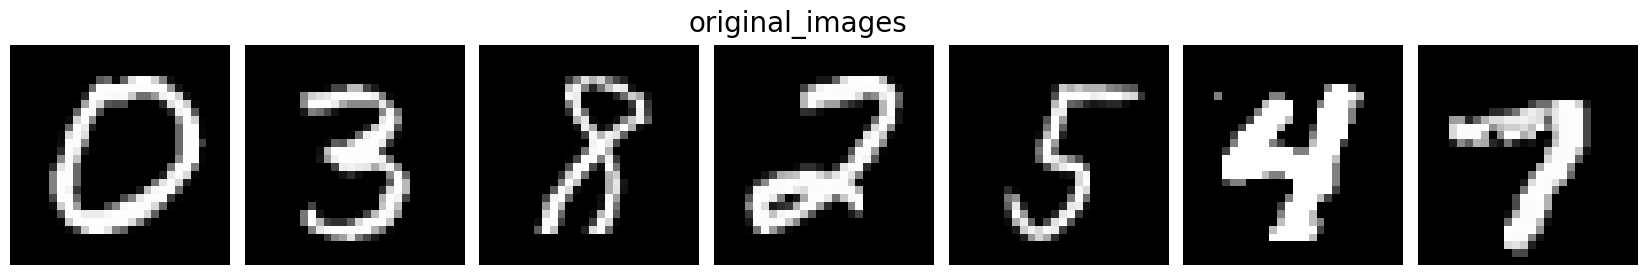

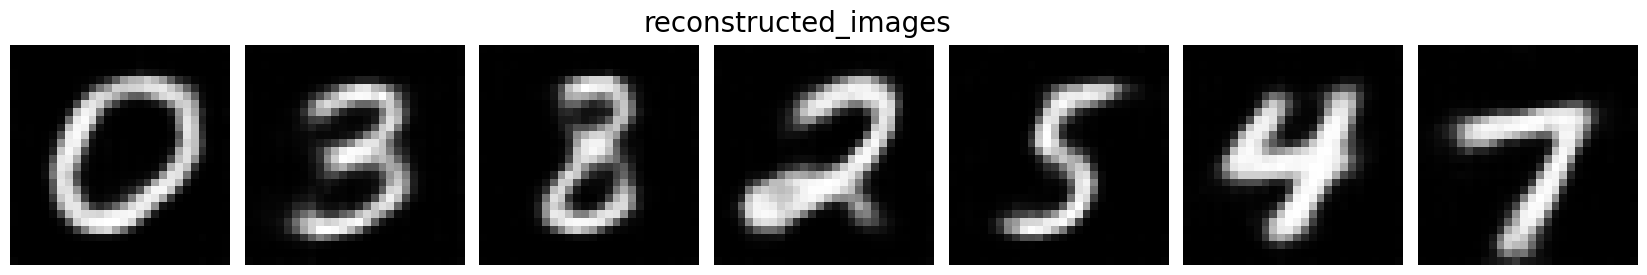

In [14]:
# Display some sample images and there reconstruction through auto encoders

images = []
cols, rows = 7, 1
for i in range(cols * rows):
  sample_idx = torch.randint(len(mnist_dataset), size=(1,)).item()
  img, label = mnist_dataset[sample_idx]
  images.append(img.squeeze())

display_image_grid(images, rows, cols, "original_images")
with torch.no_grad():
  reconstructed_images = model(torch.stack(images).unsqueeze(1).to(device))[0].cpu()
display_image_grid(reconstructed_images.squeeze(1), rows, cols, "reconstructed_images")


### Generation through Variational AutoEncoders

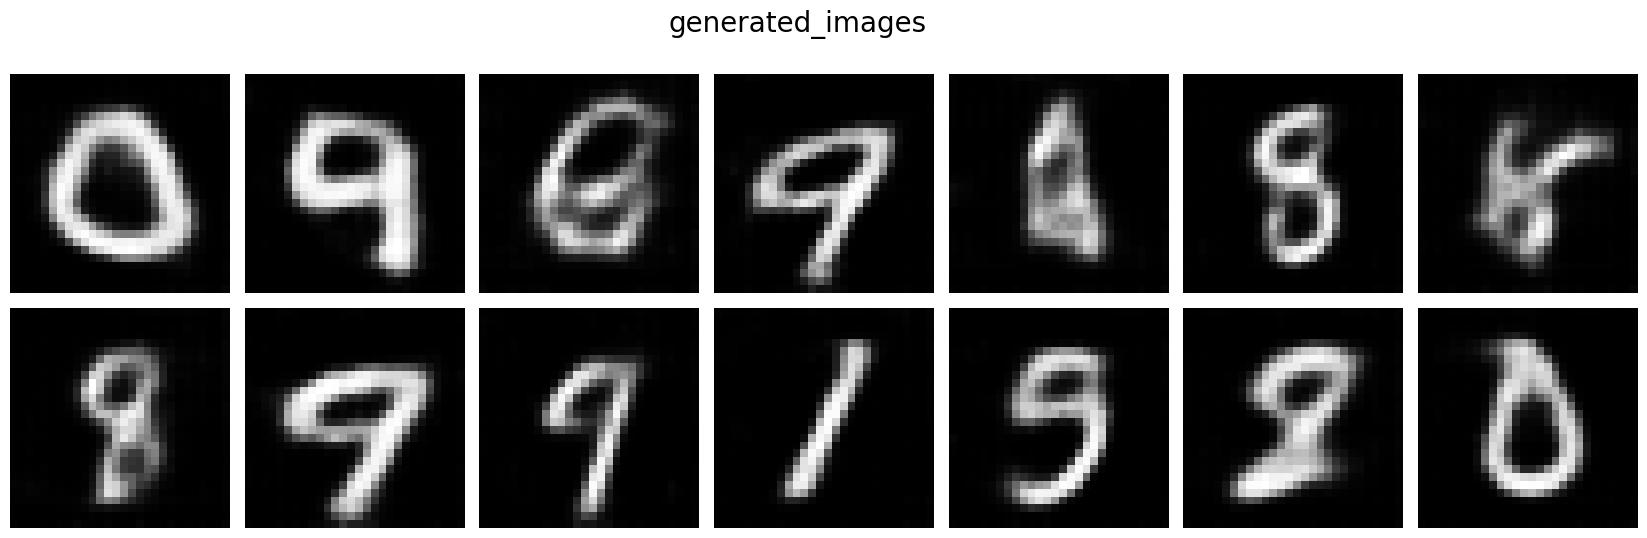

In [15]:
# Now we will try some actual generation. We will sample the encodings randomly and then pass them through decoder

rows, cols = 2, 7
sample_encodings = torch.randn(rows*cols, Z).to(device)
with torch.no_grad():
  generations = model.decoder(sample_encodings).cpu()
display_image_grid(generations.squeeze(1), rows, cols, "generated_images")

### Discussion

With Variational AutoEncoders, we sacrificed a little in reconstruction but in the end we got some decent generations from completely random inputs. But as it can be seen, they are blurry. This is one of the shortcommings of VAEs, that they produce blurry images.

In [17]:
model

VariationalAutoEncoder(
  (encoder_top): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1024, out_features=128, bias=True)
    (11): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slope=0.01)
  )
  (mu_layer): Linear(in_features=128, out_features=32, bias=True)
  (logvar_layer): Linear(in_